In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

Load Fashion MNIST Dataset

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#x_train = x_train[..., tf.newaxis]   # normally x_train.shape is (60000, 28, 28), with adding tf.newaxis we get x_train.shape as (60000, 28, 28, 1)
#x_test = x_test[..., tf.newaxis]     # normally x_test.shape is (60000, 28, 28), with adding tf.newaxis we get x_test.shape as (60000, 28, 28, 1)

x_train = tf.cast(tf.reshape(x_train, shape=(60000, 784)), tf.float32)
x_test = tf.cast(tf.reshape(x_test, shape=(10000, 784)), tf.float32)

print(x_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 784)


In [48]:
class CustomBinaryClassifierModel(tf.keras.Model):
    def __init__(self, input_shape):
        super().__init__()
        self.model = self.create_custom_model(input_shape)
        self.loss_tracker = keras.metrics.Mean(name='loss')
        self.mae_metric = keras.metrics.MeanAbsoluteError()
        self.accuracy_metric = keras.metrics.Accuracy()
        # https://keras.io/api/metrics/

    def create_custom_model(self, input_shape):
        input = keras.Input(shape=input_shape)
        output = keras.layers.Dense(1)(input)
        return keras.models.Model(input, output)

    def call(self, x):
        return self.model(x)

    def train_step(self, data):
        x, y = data  # Data structure depends on your model and on what you pass to fit()

        with tf.GradientTape() as tape:
            y_pred = self.model(x, training=True)  # Forward pass
            # Compute custom Loss value
            # loss = self.compute_loss(y=y, y_pred=y_pred)
            loss = keras.losses.mean_squared_error(y, y_pred)
            # https://keras.io/api/losses/

        # Compute Gradients
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute your custom metrics
        self.loss_tracker.update_state(loss)
        self.mae_metric.update_state(y, y_pred)
        self.accuracy_metric.update_state(y, y_pred)

        return {'loss': self.loss_tracker.result(), 'mae': self.mae_metric.result(), 'accuracy': self.accuracy_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker, self.mae_metric, self.accuracy_metric]

In [62]:
# Construct an instance of CustomModel
binary_classifier_model = CustomBinaryClassifierModel(input_shape=(32,))

# We don't passs a loss or metrics here.
binary_classifier_model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))

binary_classifier_model_hist = binary_classifier_model.fit(x, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 3ms/step - loss: 0.2549 - mae: 0.4171 - accuracy: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2368 - mae: 0.3952 - accuracy: 0.0000e+00
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2254 - mae: 0.3887 - accuracy: 0.0000e+00
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2136 - mae: 0.3723 - accuracy: 0.0000e+00
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2025 - mae: 0.3636 - accuracy: 0.0000e+00


In [63]:
predictions_nump = binary_classifier_model.predict(x)

32/32 [==============================] - 0s 1ms/step


In [64]:
predictions_tensor = binary_classifier_model(x)

In [65]:
predictions_nump[:5]   # Show a sample of predictions_nump

array([[0.9808682 ],
       [0.68529844],
       [0.6277329 ],
       [0.6436321 ],
       [0.929908  ]], dtype=float32)

In [66]:
predictions_tensor[:5]   # Show a sample of predictions_tensor

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.9808682 ],
       [0.68529844],
       [0.6277329 ],
       [0.6436321 ],
       [0.929908  ]], dtype=float32)>

<Axes: >

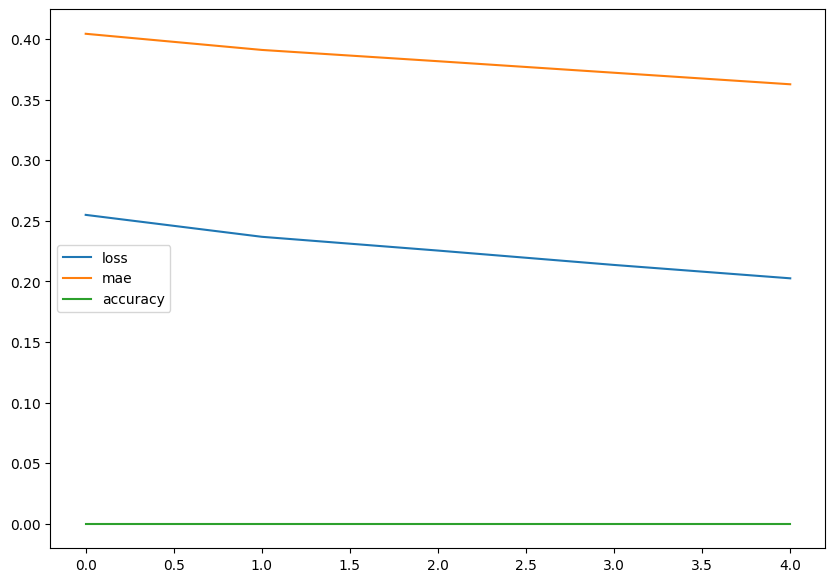

In [68]:
pd.DataFrame(binary_classifier_model_hist.history).plot(figsize=(10, 7))

Train with batches

In [69]:
# Construct an instance of CustomModel
binary_classifier_model = CustomBinaryClassifierModel(input_shape=(32,))

# We don't passs a loss or metrics here.
binary_classifier_model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))

binary_classifier_model_hist = binary_classifier_model.fit(x, y, batch_size=32, epochs=5)

Epoch 1/5
32/32 [==============================] - 0s 3ms/step - loss: 1.8353 - mae: 1.3917 - accuracy: 0.0000e+00
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.8469 - mae: 0.8916 - accuracy: 0.0000e+00
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.3984 - mae: 0.5621 - accuracy: 0.0000e+00
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2435 - mae: 0.4138 - accuracy: 0.0000e+00
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2044 - mae: 0.3696 - accuracy: 0.0000e+00


Reference:

https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit